## Submanifold Closure

In [11]:
%load_ext autoreload
import jax.numpy as jnp
from jaxtyping import Array
import matplotlib.pyplot as plt
import dynamiqs as dq
import strawberryfields as sf
import os
from controllers import ControlVector, SinusoidalControl, ConstantControl, FrequencyControl, GaussianControl
from optimizers import ClosedQuantumSystem, OptimalController
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Drift

In [12]:
alpha = .1
beta = .2
delta = .5+.4j
gamma = .1
epsilon = 1.5 + 2j
def c(v):
    return jnp.conj(v)
H_0 = jnp.array(
    [
        [1.0,       alpha,      beta,       0.0,        0.0],
        [c(alpha),  2,          delta,      0.0,        0.0],
        [c(beta),   c(delta),   3,          gamma,      0.0],
        [0.0,       0.0,        c(gamma),   4,          epsilon],
        [0.0,       0.0,        0.0,        c(epsilon), 5]
    ]
)

### Controls

In [31]:
H_1 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_2 = jnp.array(
    [
        [0.0,  1.0,  0.0,  0.0,  0.0],
        [1.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_3 = jnp.array(
    [
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  1.0,  0.0],
        [0.0,  0.0,  1.0,  0.0,  0.0],
        [0.0,  0.0,  0.0,  0.0,  0.0]
    ]
)
H_M = [H_1, H_2, H_3]
ppc = [3,3,3] # pulse per control
u_M = ControlVector(
    [
        GaussianControl(
            amp=1.0*jnp.ones((ppc[0],)),
            mean=jnp.linspace(3,9,ppc[0]),
            sigma=jnp.ones((ppc[0],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[1],)),
            mean=jnp.linspace(2,10,ppc[1]),
            sigma=1.0*jnp.ones((ppc[1],))
        ),
        GaussianControl(
            amp=1.0*jnp.ones((ppc[2],)),
            mean=jnp.linspace(2,12,ppc[2]),
            sigma=1.0*jnp.ones((ppc[2],))
        )
    ]
)

In [32]:
closure_sys = ClosedQuantumSystem(
    dim=5,
    H_0=H_0,
    H_M=H_M
)
psi0 = dq.fock(5, 0)
duration=15

## State Exclusion
go to 2, avoid 3,4

In [33]:
# project into 3rd
proj = dq.fock_dm(5,2)
def y_final(y: Array) -> float:
    return 1000*(1 - dq.expect(proj, y))

# don't go above 3
exclude_upper = dq.fock_dm(5,3) #+ dq.fock_dm(5,4)
def y_statewise(y: Array, t: float) -> float:
    return dq.expect(exclude_upper, y) 

In [34]:
controller = OptimalController(
    system=closure_sys,
    controls=u_M,
    y0=psi0,
    duration=duration,
    y_final=y_final,
    y_statewise=y_statewise
)
exp_ops = [dq.number(5),proj]
exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_54927/3636940499.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


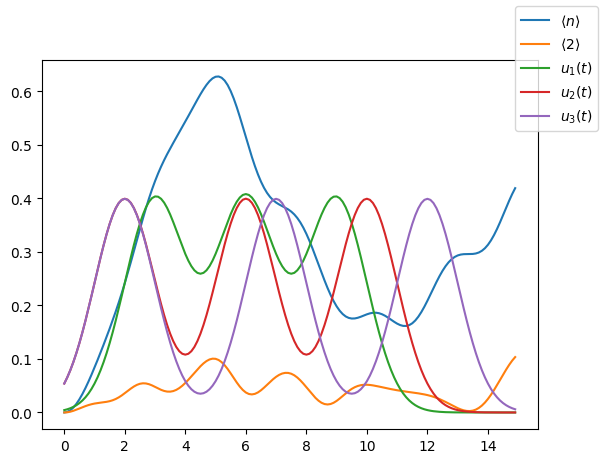

In [35]:
fig_pre, ax_pre = plt.subplots()
controller.plot(ax_pre,
                exp_ops=exp_ops,
                exp_names=exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [36]:
opt_controller = controller.optimize(
    N_steps=60,
    learning_rate=.1,
    verbosity=1)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 898.67822265625
Step: 1 Loss: 692.931396484375
Step: 2 Loss: 459.9109191894531
Step: 3 Loss: 215.24459838867188
Step: 4 Loss: 91.94905090332031
Step: 5 Loss: 52.75556182861328
Step: 6 Loss: 23.42165184020996
Step: 7 Loss: 27.636375427246094
Step: 8 Loss: 64.7026596069336
Step: 9 Loss: 63.912353515625
Step: 10 Loss: 16.750778198242188
Step: 11 Loss: 7.5501885414123535
Step: 12 Loss: 7.4440107345581055
Step: 13 Loss: 6.730465888977051
Step: 14 Loss: 5.329989433288574
Step: 15 Loss: 4.413433074951172
Step: 16 Loss: 4.234396457672119
Step: 17 Loss: 4.183136940002441
Step: 18 Loss: 3.864213705062866
Step: 19 Loss: 3.487215518951416
Step: 20 Loss: 3.274601936340332
Step: 21 Loss: 3.217839002609253
Step: 22 Loss: 3.2115719318389893
Step: 23 Loss: 3.185537099838257
Step: 24 Loss: 3.141666889190674
Step: 25 Loss: 3.075605869293213
Step: 26 Loss: 2.994410514831543
Step: 27 Loss: 2.9010279178619385
Step: 28 Loss: 2.810488224029541
Step: 29 Loss: 2.7188186645507812
Step: 30 Loss: 2.6

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_54927/2321787608.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


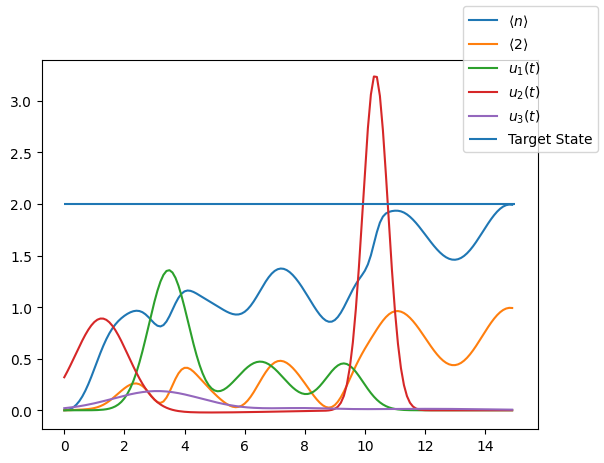

In [37]:
fig_post, ax_post = plt.subplots()
opt_controller.plot(ax_post,
                exp_ops=exp_ops,
                exp_names=exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State")
fig_post.legend()
fig_post.show()

## Submanfold Stabilization
Go to 3, stay in 2,3

In [38]:
# project into 3rd
proj3 = dq.fock_dm(5,2)
def hit3(y: Array) -> float:
    return 1000*(1 - dq.expect(proj3, y))

# don't leave 2,3
def heaviside(t: float):
    return 1.0*(t > 0)
hold23 = dq.fock_dm(5,1) + dq.fock_dm(5,2)
def stay23(y: Array, t: float) -> float:
    return heaviside(t-5)*(1 - dq.expect(hold23, y))

In [39]:
manifold_controller = OptimalController(
    system=closure_sys,
    controls=u_M,
    y0=psi0,
    duration=duration,
    y_final=hit3,
    y_statewise=stay23
)
m_exp_ops = [dq.number(5),proj3, hold23]
m_exp_names = [r"$\langle n \rangle$", r"$\langle 2 \rangle$", r"$\langle 2, 3 \rangle$"]

### Pre-Train

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_54927/1240978354.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


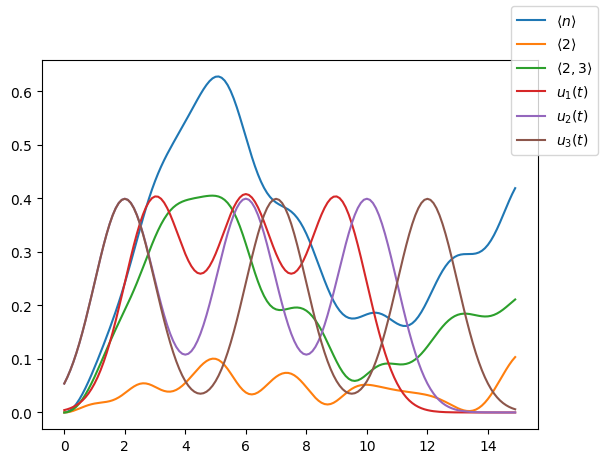

In [40]:
fig_pre, ax_pre = plt.subplots()
manifold_controller.plot(ax_pre,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
fig_pre.legend()
fig_pre.show()

### Train

In [43]:
opt_manifold_controller = manifold_controller.optimize(
    N_steps=80,
    learning_rate=.1,
    verbosity=1
)

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.


Step: 0 Loss: 978.412841796875
Step: 1 Loss: 689.6065673828125
Step: 2 Loss: 417.350830078125
Step: 3 Loss: 206.24131774902344
Step: 4 Loss: 79.35299682617188
Step: 5 Loss: 195.4116973876953
Step: 6 Loss: 220.5734100341797
Step: 7 Loss: 35.52943420410156
Step: 8 Loss: 26.291362762451172
Step: 9 Loss: 28.15703010559082
Step: 10 Loss: 27.935667037963867
Step: 11 Loss: 25.169143676757812
Step: 12 Loss: 21.55583953857422
Step: 13 Loss: 19.127920150756836
Step: 14 Loss: 18.911724090576172
Step: 15 Loss: 21.832212448120117
Step: 16 Loss: 29.23509407043457
Step: 17 Loss: 21.252235412597656
Step: 18 Loss: 18.630970001220703
Step: 19 Loss: 17.78307342529297
Step: 20 Loss: 17.168689727783203
Step: 21 Loss: 16.850820541381836
Step: 22 Loss: 16.60546875
Step: 23 Loss: 16.385868072509766
Step: 24 Loss: 16.146074295043945
Step: 25 Loss: 15.900240898132324
Step: 26 Loss: 15.671445846557617
Step: 27 Loss: 15.46070384979248
Step: 28 Loss: 15.27072525024414
Step: 29 Loss: 15.093938827514648
Step: 30 Los

/home/cjblake/miniconda3/envs/jiang/lib/python3.12/site-packages/equinox/_jit.py:51: UserWarning: Complex dtype support is work in progress, please read https://github.com/patrick-kidger/diffrax/pull/197 and proceed carefully.
/tmp/ipykernel_54927/3566152222.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


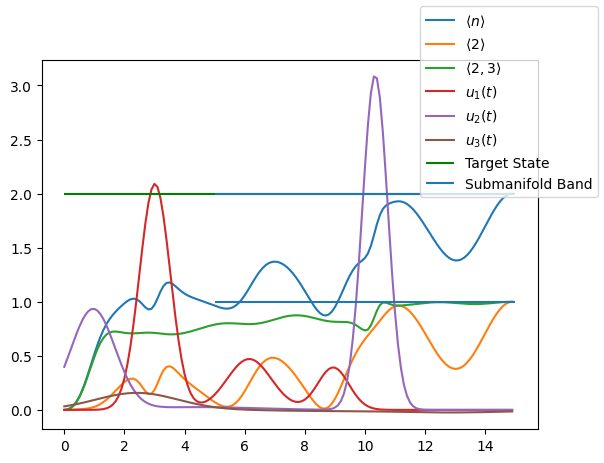

In [45]:
fig_post, ax_post = plt.subplots()
opt_manifold_controller.plot(ax_post,
                exp_ops=m_exp_ops,
                exp_names=m_exp_names)
ax_post.hlines(y=[2.0],xmin=0,xmax=duration,label="Target State",color='green')
ax_post.hlines(y=[1.0,2.0],xmin=5,xmax=duration,label="Submanifold Band")
fig_post.legend()
fig_post.show()